In [134]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner import HyperModel

NUMERIC_FEATURES = [
    'p1_height',
    'p2_height',
    'p1_age',
    'p2_age',
    'p1_rating',
    'p2_rating',
    'p1_dev',
    'p2_dev',
    'p1_surface_rating',
    'p2_surface_rating',
    'p1_surface_dev',
    'p2_surface_dev',
    'p1_w',
    'p2_w',
    'p1_l',
    'p2_l',
    'p1_surface_w',
    'p2_surface_w',
    'p1_surface_l',
    'p2_surface_l',
    'p1_inactive_days',
    'p2_inactive_days',
    'p1_recent_rating',
    'p2_recent_rating'
]
CATEGORICAL_FEATURES = [
    'is_hard',
    'is_clay',
    'is_grass',
    'is_bo5',
    'p1_lefty',
    'p2_lefty',
    'p1_home',
    'p2_home'
    
]

dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
validation = pd.read_csv('../data/matches.csv')[76425:]


def build_model(preprocessing_head, inputs, hidden_layer, learning_rate, dropout):
  body = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(32,)),
    keras.layers.Dense(hidden_layer, activation='relu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics='acc')
  return model


In [135]:
class MyHyperModel(HyperModel):
    def __init__(self, preprocessing_head, inputs):
        self.preprocessing_head = preprocessing_head
        self.inputs = inputs
    def build(self, hp):
        body = tf.keras.Sequential([
            keras.layers.InputLayer(input_shape=(32,)),
            keras.layers.Dense(hp.Int('hidden_size', 200, 600), activation='relu'),
            keras.layers.Dropout(hp.Float('dropout', 0.05, 0.5)),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        preprocessed_inputs = self.preprocessing_head(self.inputs)
        result = body(preprocessed_inputs)
        model = tf.keras.Model(self.inputs, result)

        model.compile(
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 0.003, 0.03)),
                      metrics=['acc']
                      )
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", 2000, 6000),
            **kwargs,
        )

In [136]:
def get_model(dataframe, hidden_layer, learning_rate, dropout):
    labels = dataframe.pop('p1_win')
    dataframe.pop('match_hash')
    dataframe.pop('tourney_name')
    dataframe.pop('tourney_date')
    dataframe.pop('p1_name')
    dataframe.pop('p2_name')

    dataframe_features = dataframe.copy()

    inputs = {}

    # match column names with input objects
    for name, column in dataframe_features.items():
        dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

    numeric_inputs = {name:input for name,input in inputs.items()
                    if name in NUMERIC_FEATURES}

    # normalize the numeric inputs and gather them in an array
    x = keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = keras.layers.Normalization()
    norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]

    for name, input in inputs.items():
        if name in NUMERIC_FEATURES:
            continue
        preprocessed_inputs.append(input)

    preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
    preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

    features_dict = {name: np.array(value) for name, value in dataframe_features.items()}
    f_dict = {name:values for name, values in features_dict.items()}
    preprocessing(f_dict)

    # data_model = MyHyperModel(preprocessing, inputs)
    data_model = build_model(preprocessing, inputs, hidden_layer, learning_rate, dropout)

    return data_model, features_dict, labels

In [137]:
for hidden_layer in range(200, 601, 100):
    for learning_rate in range(1,32,10):
        learning_rate = learning_rate / 1000
        for int_dropout in range(15, 46, 10):
            dropout = int_dropout / 100
            dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
            validation = pd.read_csv('../data/matches.csv')[76425:]
            data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
            _, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)

            for trial in range(3):
                data_model.fit(x=features_dict, y=labels, epochs=20000, batch_size=6000, 
                            callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)],
                            validation_data=(val_features_dict, val_labels),
                        )
                # data_model.save(f'test{trial}')
                data_model.save(f'hidden{hidden_layer}lr{learning_rate}dropout{dropout}trial{trial}')



# data_model, features_dict, labels = get_model(dataframe, 0,0,0)
# _, val_features_dict, val_labels = get_model(validation, 0,0,0)
# tuner = kt.BayesianOptimization(data_model, objective='loss', directory='training_weights', max_trials=80)
# tuner.search(x=features_dict, y=labels, epochs=20000, 
#              validation_data=(val_features_dict, val_labels),
#              callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)]
#             )

Epoch 1/20000
12/12 [==============================] - 2s 95ms/step - loss: 0.6516 - acc: 0.6156 - val_loss: 0.6113 - val_acc: 0.6624
Epoch 2/20000
12/12 [==============================] - 1s 48ms/step - loss: 0.6273 - acc: 0.6494 - val_loss: 0.5906 - val_acc: 0.6789
Epoch 3/20000
12/12 [==============================] - 1s 47ms/step - loss: 0.6228 - acc: 0.6524 - val_loss: 0.5940 - val_acc: 0.6779
Epoch 4/20000
12/12 [==============================] - 1s 51ms/step - loss: 0.6197 - acc: 0.6546 - val_loss: 0.5894 - val_acc: 0.6842
Epoch 5/20000
12/12 [==============================] - 1s 46ms/step - loss: 0.6180 - acc: 0.6563 - val_loss: 0.5839 - val_acc: 0.6905
Epoch 6/20000
12/12 [==============================] - 1s 48ms/step - loss: 0.6168 - acc: 0.6567 - val_loss: 0.5800 - val_acc: 0.6943
Epoch 7/20000
12/12 [==============================] - 1s 46ms/step - loss: 0.6158 - acc: 0.6569 - val_loss: 0.5776 - val_acc: 0.6988
Epoch 8/20000
12/12 [==============================] - 1s 45ms

INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial0\assets


INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial0\assets


Epoch 1/20000
12/12 [==============================] - 1s 57ms/step - loss: 0.5854 - acc: 0.6837 - val_loss: 0.4385 - val_acc: 0.8154
Epoch 2/20000
12/12 [==============================] - 1s 63ms/step - loss: 0.5860 - acc: 0.6833 - val_loss: 0.4381 - val_acc: 0.8132
Epoch 3/20000
12/12 [==============================] - 1s 42ms/step - loss: 0.5859 - acc: 0.6834 - val_loss: 0.4405 - val_acc: 0.8136
Epoch 4/20000
12/12 [==============================] - 1s 45ms/step - loss: 0.5861 - acc: 0.6838 - val_loss: 0.4398 - val_acc: 0.8134
Epoch 5/20000
12/12 [==============================] - 1s 46ms/step - loss: 0.5859 - acc: 0.6836 - val_loss: 0.4399 - val_acc: 0.8139
Epoch 6/20000
12/12 [==============================] - 1s 46ms/step - loss: 0.5863 - acc: 0.6831 - val_loss: 0.4403 - val_acc: 0.8124
Epoch 7/20000
12/12 [==============================] - 1s 47ms/step - loss: 0.5857 - acc: 0.6842 - val_loss: 0.4385 - val_acc: 0.8141
Epoch 8/20000
12/12 [==============================] - 1s 48ms

INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial1\assets


INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial1\assets


Epoch 1/20000
12/12 [==============================] - 1s 59ms/step - loss: 0.5844 - acc: 0.6849 - val_loss: 0.4370 - val_acc: 0.8147
Epoch 2/20000
12/12 [==============================] - 1s 50ms/step - loss: 0.5847 - acc: 0.6856 - val_loss: 0.4348 - val_acc: 0.8167
Epoch 3/20000
12/12 [==============================] - 1s 45ms/step - loss: 0.5841 - acc: 0.6857 - val_loss: 0.4354 - val_acc: 0.8164
Epoch 4/20000
12/12 [==============================] - 1s 47ms/step - loss: 0.5842 - acc: 0.6842 - val_loss: 0.4336 - val_acc: 0.8168
Epoch 5/20000
12/12 [==============================] - 1s 43ms/step - loss: 0.5847 - acc: 0.6845 - val_loss: 0.4359 - val_acc: 0.8168
Epoch 6/20000
12/12 [==============================] - 1s 44ms/step - loss: 0.5839 - acc: 0.6856 - val_loss: 0.4349 - val_acc: 0.8166
Epoch 7/20000
12/12 [==============================] - 1s 45ms/step - loss: 0.5846 - acc: 0.6844 - val_loss: 0.4337 - val_acc: 0.8165
Epoch 8/20000
12/12 [==============================] - 1s 44ms

INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial2\assets


INFO:tensorflow:Assets written to: hidden200lr0.001dropout0.15trial2\assets


2158/2158 [==============================] - 9s 4ms/step


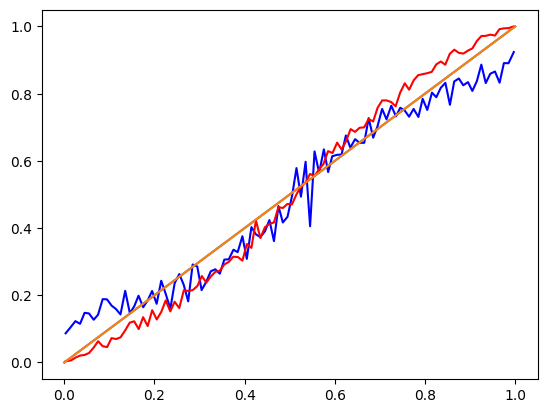

In [ ]:
# reloaded = tf.keras.models.load_model('test0')
# results = reloaded.evaluate(val_features_dict, val_labels)
# val_predictions = reloaded.predict(val_features_dict)
# val_labels_list = val_labels.tolist()

# predictions = reloaded.predict(features_dict)
# labels_list = labels.tolist()

# from sklearn.calibration import calibration_curve
# import matplotlib.pyplot as plt

# x, y = calibration_curve(val_labels_list, val_predictions, n_bins = 100)
# plt.plot(y, x, 'b')
# plt.plot([0, 1], [0, 1])

# x, y = calibration_curve(labels_list, predictions, n_bins = 100)
# plt.plot(y, x, 'r')
# plt.plot([0, 1], [0, 1])


#_____________________________________________________________
# validation = pd.read_csv('../data/matches.csv')[85000:]
# _, val_features_dict, val_labels = get_model(validation)


# data_model.load_weights('asdf/metrics')
# results = data_model.evaluate(val_features_dict, val_labels)
# predictions = data_model.predict(val_features_dict)
# labels_list = val_labels.tolist()
# print(len(val_features_dict), len(labels_list))
# print(val_features_dict)

# for i in range(0, len(predictions)):
#     print('Prediction:', predictions[i], 'Result:', labels_list[i])

